In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

2024-10-17 16:04:28.317882: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-17 16:04:28.557037: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-17 16:04:28.741768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 16:04:28.896241: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 16:04:28.965076: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 16:04:29.620513: I tensorflow/core/platform/cpu_feature_gu

In [2]:
(train, test),ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:75%]', 'train[75%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

I0000 00:00:1729191873.008043   26244 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-17 16:04:33.009497: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


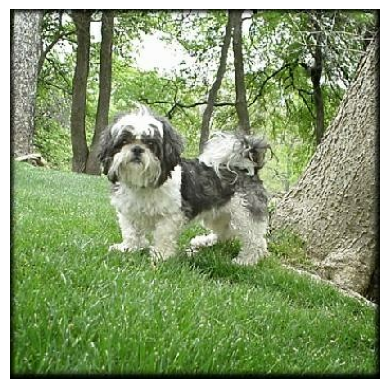

In [3]:
example_image, _ = next(iter(tfds.as_numpy(train)))
example_image = tf.image.convert_image_dtype(example_image, dtype=tf.float32)


plt.imshow(example_image)
plt.axis('off')
plt.show()

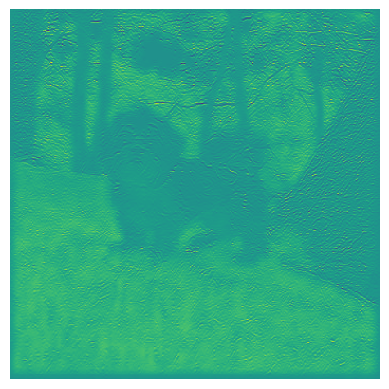

In [4]:
kernel = tf.constant([
    [[[-1], [-1], [-1]]],
    [[[-1],  [8], [-1]]],
    [[[-1], [-1], [-1]]],
], dtype=tf.float32)

example_image = tf.expand_dims(example_image, 0)

filtered_image = tf.nn.conv2d(
    example_image,
    kernel,
    strides=1,
    padding='SAME',
)

plt.imshow(tf.squeeze(filtered_image))
plt.axis('off')
plt.show()

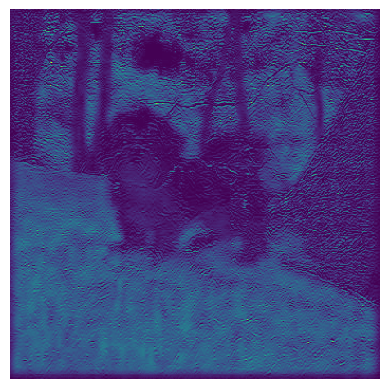

In [5]:
relu_image = tf.nn.relu(filtered_image)
plt.imshow(tf.squeeze(relu_image))
plt.axis('off')
plt.show()

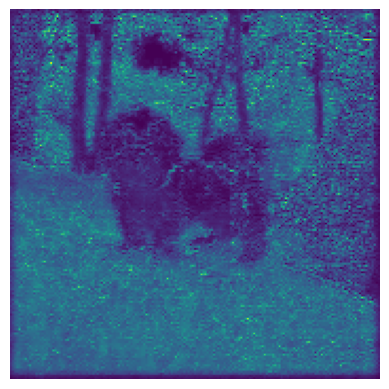

In [6]:
pool_image = tf.nn.max_pool2d(
    relu_image, 
    ksize=(2, 2),
    strides=(2,2), 
    padding="VALID")

plt.imshow(tf.squeeze(pool_image))
plt.axis('off')
plt.show()

---

In [7]:
model = tf.keras.Sequential([
    # data augmentation
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    
    # 100x100
    layers.Conv2D(32, 3, strides=1, activation="relu", input_shape=(100, 100, 3)),
    layers.MaxPool2D(),

    # 50x50
    layers.Conv2D(64, 3, strides=1, activation="relu"),
    layers.MaxPool2D(),

    # 25x25
    layers.Conv2D(128, 3, strides=1, activation="relu"),
    layers.MaxPool2D(pool_size=(3,3)),

    # prediction head
    # 9x9
    layers.Flatten(),
    layers.Dense(9*9, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

In [8]:
def normalize_img(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, (100,100))
    image /= 255.0
    return image, label

train = train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
train = train.cache()
train = train.shuffle(ds_info.splits['train'].num_examples)
train = train.batch(128)
train = train.prefetch(tf.data.AUTOTUNE)

In [9]:
test = test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test = test.batch(128)
test = test.cache()
test = test.prefetch(tf.data.AUTOTUNE)

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

In [11]:
model.fit(
    train,
    epochs=20,
    validation_data=test)

Epoch 1/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - binary_accuracy: 0.4981 - loss: 0.6932 - val_binary_accuracy: 0.4940 - val_loss: 0.6931
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 126s 923ms/step - binary_accuracy: 0.5043 - loss: 0.6931 - val_binary_accuracy: 0.4940 - val_loss: 0.6932
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 126s 917ms/step - binary_accuracy: 0.5111 - loss: 0.6930 - val_binary_accuracy: 0.4940 - val_loss: 0.6932
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 138s 890ms/step - binary_accuracy: 0.5118 - loss: 0.6930 - val_binary_accuracy: 0.4986 - val_loss: 0.6930
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 145s 912ms/step - binary_accuracy: 0.5144 - loss: 0.6929 - val_binary_accuracy: 0.5330 - val_loss: 0.6929
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 125s 912ms/step - binary_accuracy: 0.5250 - loss: 0.6913 - val_binary_accuracy: 0.5528 - val_loss: 0.6866
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 134s 976ms/step - binary_accuracy: 0.5564 - loss: 0.6853 - val_binary_accuracy: 0.5619 

In [12]:
model.save("model.keras")